# Import Data

In [1]:
locations = {}

# Load factors are proportional to revenue for each renewable
solar_load_factor = 0.11
onshore_wind_load_factor = 0.34
offshore_wind_load_factor = 0.51

# .csv columns: Area split for the UK, Number of units per region, Generated energy per unit (GWh/year), Weather (sun hours/month), Total capacity (MW), Total energy (GWh), Revenue per unit, Cost per unit, Solar P/L
file = open('solar.csv', 'r')
solar = file.readlines()
for line in solar:
    line.strip('\n')
    columns = line.split(',')
    locations[columns[0]] = {}
    locations[columns[0]]['solar'] = [float(columns[1])*solar_load_factor*float(columns[6]),float(columns[1])*float(columns[7])]
file.close()

# .csv columns: Area split for the UK, Number of units per region, Total energy (GWh/year), Total capacity (MW), Total energy per unit, Revenue per unit, Cost per unit, On-shore P/L
file = open('onshore.csv', 'r')
solar = file.readlines()
for line in solar:
    line.strip('\n')
    columns = line.split(',')
    locations[columns[0]]['onshore'] = [float(columns[1])*onshore_wind_load_factor*float(columns[5]),float(columns[1])*float(columns[6])]
file.close()

# .csv columns: Area split for the UK, Number of units per region, Total energy (GWh/year), Total capacity (MW), Total energy per unit, Revenue per unit, Cost per unit, Off-shore P/L
file = open('offshore.csv', 'r')
solar = file.readlines()
for line in solar:
    line.strip('\n')
    columns = line.split(',')
    locations[columns[0]]['offshore'] = [float(columns[1])*offshore_wind_load_factor*float(columns[5]),float(columns[1])*float(columns[6])]
file.close()

# dictionary: location -> source -> [revenue, cost]

# Minimize Using Quantum Circuit

In [2]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

In [3]:
# Renewable sources: solar, on-shore and off-shore wind turbines
number_of_renewable_sources = len(locations[next(iter(locations))])
# Locations: England, Northern Ireland, Scotland, Wales
number_of_locations = len(locations)

# Calculate the number of qubits needed, 
# NOTE: IBMQ systems accesible have 5 qubits
nqubits = number_of_locations * number_of_renewable_sources

G = nx.complete_graph(nqubits)

total_cost = C = 61510030000.0 # units: £

In [4]:
# Renewable sources: solar, on-shore and off-shore wind turbines
number_of_renewable_sources = len(locations[next(iter(locations))])
# Locations: England, Northern Ireland, Scotland, Wales
number_of_locations = len(locations)

# Calculate the number of qubits needed, 
# NOTE: IBMQ systems accesible have 5 qubits
nqubits = number_of_locations * number_of_renewable_sources

G = nx.complete_graph(nqubits)

total_cost = C = 61510030000.0 # units: £

# lambda and gamma, the initial parameter guess for the cost function
lam, gam = 1.0, 1.0

# Calculate the total costs and revenues 
a_revs, b_costs = [], []

for key in locations:
    for source in locations[key]:
        a_revs.append(locations[key][source][0])
        b_costs.append(locations[key][source][1])

In [5]:
def cost_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """

    obj = lam * C**2
    for i in G.nodes():
        obj += (lam * a_revs[i]**2 + gam * b_costs[i] - 2*lam*C*a_revs[i]) * int(x[i])

    for i, j in G.edges():
        obj += 2 * lam * a_revs[i] * a_revs[j] * int(x[i]) * int(x[j])
            
    return obj

In [6]:
def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = cost_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [7]:
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary biases
        for i in list(G.nodes()):
            qc.rz(2 * gamma[irep], i)
        # problem unitary couplings
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

In [8]:
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [9]:
expectation = get_expectation(G, p=1)

res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: 3.2607294048587644e+21
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([2.7175717 , 2.70630467])

In [10]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)
# Visualise the quantum circuit
qc_res.draw(output='mpl')

ValueError: Image size of 1621x157928 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1621.88x157929 with 1 Axes>

<ipython-input-11-5bb77e3a9467>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xs, fontsize=10, rotation=-45)


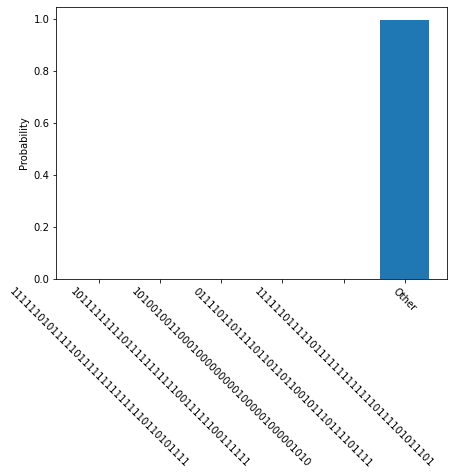

In [11]:
# Obtain simulation results
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
strings = list(counts.keys())
probabilities = np.array([counts[string]/1024 for string in strings])

# Plot the first 5 highest scores (energy sources and corresponding locations)
num_highest = 5
perm = np.flip((np.argsort(probabilities)))
indices = perm[0:num_highest]
xs = [strings[i] for i in indices] + ["Other"]
ys = [probabilities[i] for i in indices] + [sum(probabilities[perm[num_highest:]])]


fig, ax = plt.subplots(1, 1,figsize=(7, 5))
ax.bar(xs, ys)
ax.set_xticklabels(xs, fontsize=10, rotation=-45)
ax.set_ylabel("Probability")
plt.show()